# Data Exploration

### Preparing data

In [29]:
# All needed imports
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import *
from surprise.accuracy import rmse, mae, fcp
from UserDefinedAlgorithm import PredictMean
from sklearn.grid_search import ParameterGrid
import pickle
from os import listdir

We will start by parsing the json files into a pandas data frame and saving it in a csv file to avoid parsing it multiple times. Afterwards, we will clean the data by keeping the necessary features only. When we finish the data pre-processing, we will do some statistical analysis on the data that will help us understand the problem better. Finally we will save the resulting dataframe in a csv file to be loaded directly for usage in the recommendation algorithms

#### prepare data in pandas dataframe

In [3]:
#read data from file 
def parse(path):
	g = open(path, 'rb')
	for l in g:
		yield eval(l)
        
#parse data into a pandas dataframe
def get_df(path):
	i = 0
	df = {}
	for d in parse(path):
		df[i] = d
		i += 1
	return pd.DataFrame.from_dict(df, orient='index')

# if the data has been parsed:
#   load it 
# else:
#   parse it, save it and load it
def possibly_get_df(path):
    try:
        df = pd.read_csv('use_item_ratings.csv')
    except IOError:
        df = get_df(path)
        df.to_csv('use_item_ratings.csv', index=False)
    return df

df = possibly_get_df('Clothing_Shoes_and_Jewelry_5.json')
df.head()

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",1297468800,This is a great tutu and at a really great pri...,5.0,"02 12, 2011",Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",1358553600,I bought this for my 4 yr old daughter for dan...,5.0,"01 19, 2013",Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",1357257600,What can I say... my daughters have it in oran...,5.0,"01 4, 2013",I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]",1398556800,"We bought several tutus at once, and they are ...",5.0,"04 27, 2014","Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",1394841600,Thank you Halo Heaven great product for Little...,5.0,"03 15, 2014",Grammy's Angels Love it


#### Create a data frame with users, items and ratings only

In [5]:
ratings_df = df[['reviewerID', 'asin','overall']]
print "Dataframe after dropping unneccessary fields:"
ratings_df.head()

Dataframe after dropping unneccessary fields:


,reviewerID,asin,overall
0,A1KLRMWW2FWPL4,0000031887,5.0
1,A2G5TCU2WDFZ65,0000031887,5.0
2,A1RLQXYNCMWRWN,0000031887,5.0
3,A8U3FAMSJVHS5,0000031887,5.0
4,A3GEOILWLK86XM,0000031887,5.0


### Statistics

#### Overall statistical analysis

In [6]:
#number of rows in dataframe  which are the total number of ratings
total_num_of_ratings = len(ratings_df)
print "total number of user-items ratings is: %d" % total_num_of_ratings

#number of unique reviewers
num_of_users = len(ratings_df['reviewerID'].unique())
print "number of unique reviewers is: %d" % num_of_users

#number of unique items
num_of_items = len(ratings_df['asin'].unique())
print "number of unique items is: %d" % num_of_items

#average rating and standar deviation
ratings_mean = ratings_df['overall'].mean()
ratings_std = ratings_df['overall'].std()
print "average rating is %.3f and standard deviation %.3f" % (ratings_mean,ratings_std)

# The sparsity of the user-item matrix
sparsity = float(total_num_of_ratings) / (num_of_users * num_of_items)
print "sparisity of the user-item matrix is %.8f" % sparsity

total number of user-items ratings is: 278677
number of unique reviewers is: 39387
number of unique items is: 23033
average rating is 4.245 and standard deviation 1.104
sparisity of the user-item matrix is 0.00030718


#### Users statitical analysis

In [7]:
users_df = ratings_df.groupby('reviewerID').size()
print "The average number of items rated by a user is %f" % np.mean(users_df)
print "The average number of items rated by a user is %f" % np.std(users_df)
print "The minimum number of items rated by a user is %d" % min(users_df)
print "The maximum number of items rated by a user is %d" % max(users_df)

The average number of items rated by a user is 7.075355
The average number of items rated by a user is 3.585205
The minimum number of items rated by a user is 5
The maximum number of items rated by a user is 136


#### Items statitical analysis

In [8]:
items_df = ratings_df.groupby('asin').size()
print "The average number of users that rated an item is %f" % np.mean(items_df)
print "The standard deviation of number of users that rated an item is %f" % np.std(items_df)
print "The minimum number of users that rated an item is %d" % min(items_df)
print "The minimum number of users that rated an item is %d" % max(items_df)

The average number of users that rated an item is 12.099032
The standard deviation of number of users that rated an item is 13.967952
The minimum number of users that rated an item is 5
The minimum number of users that rated an item is 441


### Visualizations

##### Distribution of ratings

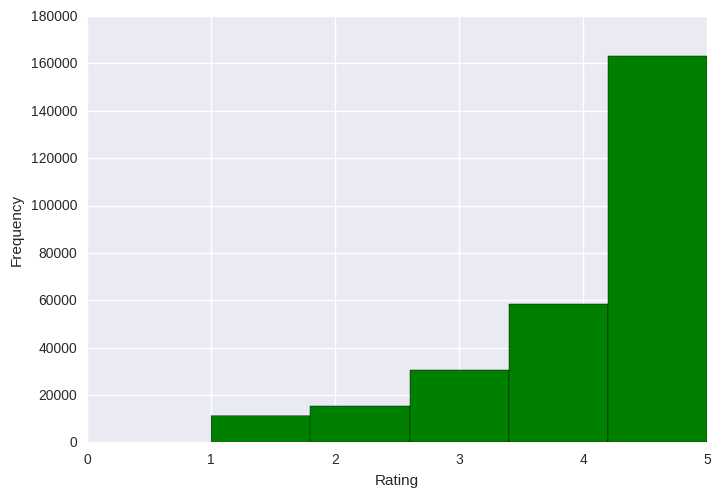

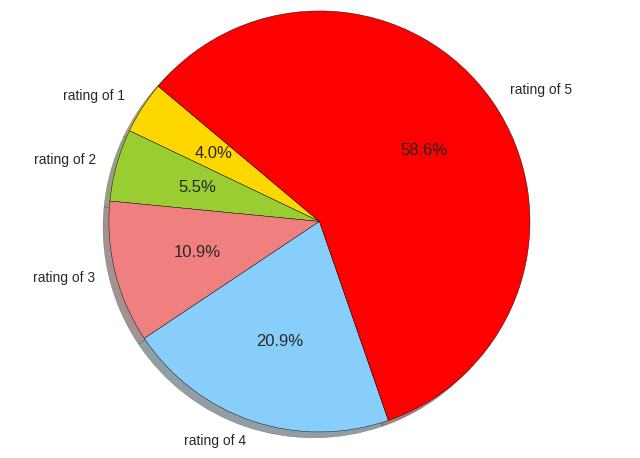

In [9]:
# frequency of each rating in a histogram
plt.figure(1)
plt.hist(ratings_df['overall'],5, facecolor='g')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.axis([0, 5, 0, 180000])

# percentage of each rating in a pie chart
plt.figure(2)
labels = 'rating of 1', 'rating of 2' ,'rating of 3', 'rating of 4','rating of 5'
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red']
plt.pie(ratings_df.groupby('overall').size(),labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')

plt.show()

### Dumping data

#### Save data in CSV

In [10]:
ratings_df.to_csv('cleaned_user_item_ratings.csv', index=False,header=False)

# Predicting

#### Load Datasets

In [12]:
# path to dataset file
original_file_path = 'cleaned_user_item_ratings.csv'

reader = Reader(line_format='user item rating', sep=',')
original_data = Dataset.load_from_file(original_file_path, reader=reader)

#Split data into 4 folds, 3 for training and 1 for testing.
original_data.split(n_folds=4)


#### Benchmark

In [13]:
# Method that will be used for all algorithm.
# Input: Algorithm to use
#       Dataset
# Output: Error measurements
def algorithm_to_results(data, algo):
    algo = algo()
    alogPerf = evaluate(algo, data,measures=['RMSE', 'FCP'], verbose=False)
    return alogPerf

In [14]:
print algorithm_to_results(original_data,PredictMean)

Evaluating RMSE, FCP of algorithm PredictMean.

        Fold 1  Fold 2  Fold 3  Fold 4  Mean    
FCP     0.0000  0.0000  0.0000  0.0000  0.0000  
RMSE    1.1017  1.1002  1.1055  1.1075  1.1037  


#### SVD Algorithm

In [15]:
print algorithm_to_results(original_data, SVD)

Evaluating RMSE, FCP of algorithm SVD.

        Fold 1  Fold 2  Fold 3  Fold 4  Mean    
FCP     0.5191  0.5192  0.5234  0.5216  0.5208  
RMSE    1.0692  1.0665  1.0726  1.0745  1.0707  


#### Baseline Algorithm

In [16]:
print algorithm_to_results(original_data, BaselineOnly)

Evaluating RMSE, FCP of algorithm BaselineOnly.

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
        Fold 1  Fold 2  Fold 3  Fold 4  Mean    
FCP     0.5272  0.5247  0.5303  0.5252  0.5268  
RMSE    1.0502  1.0475  1.0539  1.0562  1.0520  


#### Co-Clustering Algorithm

In [17]:
print algorithm_to_results(original_data, CoClustering)

Evaluating RMSE, FCP of algorithm CoClustering.

        Fold 1  Fold 2  Fold 3  Fold 4  Mean    
FCP     0.5101  0.5102  0.5120  0.5158  0.5120  
RMSE    1.1671  1.1676  1.1688  1.1824  1.1715  


# Optimizing

#### Functions to tune parameters
We define a function where we give it a dictionary with different value for each parameter and it returns an accuracy measure for each combination. Insprised from GridSearchCV of sklearn

In [20]:
# return the average accuracy measure on different test sets
def get_folds_mean(algo, data, accuracy=['RMSE']):
    measures_list = []
    for trainset, testset in data.folds():
        algo.train(trainset)
        predictions = algo.test(testset)
        accuracy_measure = []
        if 'RMSE' in accuracy:
            accuracy_measure.append(rmse(predictions, verbose=False))
        if 'MAE' in accuracy:
            accuracy_measure.append(mae(predictions, verbose=False))
        if 'FCP' in accuracy:
            accuracy_measure.append(fcp(predictions, verbose=False))
        measures_list.append(accuracy_measure)
    return np.mean(measures_list,axis=0)

# return a list of tuples of each parameter combination and its correcsponding accuracy measure
def compute_all_combinations(combinations_list,algo, data, accuracy=['RMSE']):
    results = []
    for combination in combinations_list:
        algo_instance = algo(**combination)
        mean_accuracy = get_folds_mean(algo_instance, data,accuracy)
        combination['measure'] = mean_accuracy
        results.append(combination)
    return results

#### Optimize SVD

##### with 20 iterations

In [21]:
""" 
    Test the SVD algorithm on 5 different learning rates each time witha different reg_all factor. n_epochs = 20
    NOTE: This block can take some time to finish
"""
print 'regularization is 0.05:'
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.05]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg2 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.1:'
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.1]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg3 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.2:'
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.2]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg4 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.4:'
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.4]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg5 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.6:'
param_grid = {'n_epochs':[20], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.6]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg6 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

regularization is 0.05:
done
regularization is 0.1:
done
regularization is 0.2:
done
regularization is 0.4:
done
regularization is 0.6:
done


In [23]:
def get_learn_measure_rmse(iterable):
    x_values = []
    y_values = []
    for item in iterable:
        x_values.append(item['lr_all'])
        y_values.append(item['measure'][0])
    return [x_values, y_values]

def get_learn_measure_fcp(iterable):
    x_values = []
    y_values = []
    for item in iterable:
        x_values.append(item['lr_all'])
        y_values.append(item['measure'][1])
    return [x_values, y_values]

#RMSE
reg2_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg2)
reg3_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg3)
reg4_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg4)
reg5_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg5)
reg6_rmse = get_learn_measure_rmse(vary_lr_rate_only_reg6)

#FCP
reg2_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg2)
reg3_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg3)
reg4_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg4)
reg5_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg5)
reg6_fcp = get_learn_measure_fcp(vary_lr_rate_only_reg6)

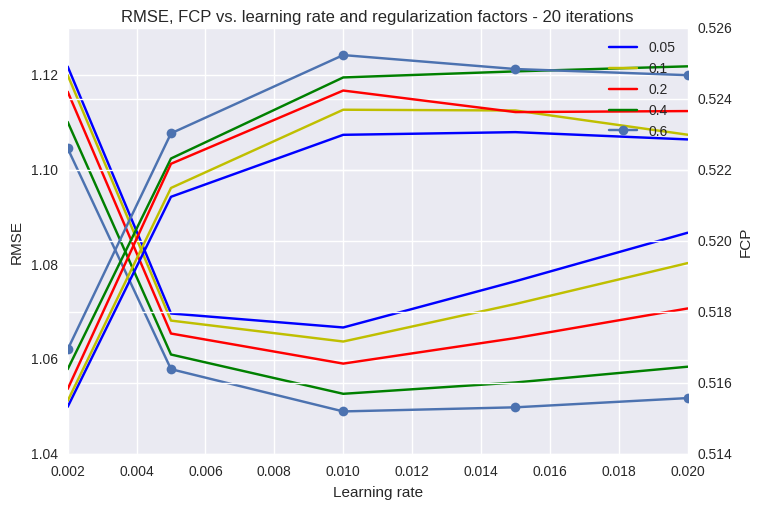

In [24]:
fig, ax1= plt.subplots()
ax1.plot(reg2_rmse[0], reg2_rmse[1], 'b-',reg3_rmse[0], reg3_rmse[1], 'y-',\
         reg4_rmse[0], reg4_rmse[1], 'r-',reg5_rmse[0], reg5_rmse[1], 'g-',reg6_rmse[0], reg6_rmse[1], 'o-')
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('RMSE')
ax2 = ax1.twinx()
ax2.plot(reg2_fcp[0], reg2_fcp[1], 'b-',reg3_fcp[0], reg3_fcp[1], 'y-',\
        reg4_fcp[0], reg4_fcp[1], 'r-',reg5_fcp[0], reg5_fcp[1], 'g-',reg6_fcp[0], reg6_fcp[1], 'o-')
ax2.set_ylabel('FCP')
labels = ['0.05','0.1','0.2','0.4','0.6']
plt.legend(labels)
plt.title('RMSE, FCP vs. learning rate and regularization factors - 20 iterations')
plt.show()

##### With 40 Iterations

In [22]:
""" 
    Test the SVD algorithm on 5 different learning rates each time witha different reg_all factor. n_epochs = 40
    NOTE: This block can take some time to finish
"""
print 'regularization is 0.05:'
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.05]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg2_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.1:'
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.1]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg3_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.2:'
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.2]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg4_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.4:'
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.4]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg5_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

print 'regularization is 0.6:'
param_grid = {'n_epochs':[40], 'lr_all': [0.002, 0.005, 0.01, 0.015, 0.02], 'reg_all': [0.6]}
combinations_list  = list(ParameterGrid(param_grid))
vary_lr_rate_only_reg6_40 = compute_all_combinations(combinations_list, SVD, original_data, accuracy=['RMSE','FCP'])
print 'done'

regularization is 0.05:
done
regularization is 0.1:
done
regularization is 0.2:
done
regularization is 0.4:
done
regularization is 0.6:
done


In [25]:
#RMSE
reg2_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg2_40)
reg3_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg3_40)
reg4_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg4_40)
reg5_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg5_40)
reg6_rmse_40 = get_learn_measure_rmse(vary_lr_rate_only_reg6_40)

#FCP
reg2_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg2_40)
reg3_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg3_40)
reg4_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg4_40)
reg5_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg5_40)
reg6_fcp_40 = get_learn_measure_fcp(vary_lr_rate_only_reg6_40)

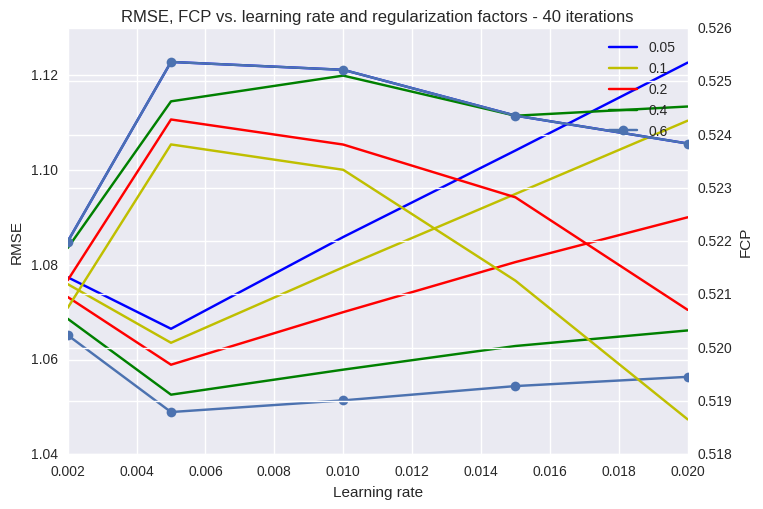

In [26]:
fig, ax1= plt.subplots()
ax1.plot(reg2_rmse_40[0], reg2_rmse_40[1], 'b-', reg3_rmse_40[0], reg3_rmse_40[1], 'y-',\
         reg4_rmse_40[0], reg4_rmse_40[1], 'r-',reg5_rmse_40[0], reg5_rmse_40[1], 'g-',\
         reg6_rmse_40[0], reg6_rmse_40[1], 'o-')
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('RMSE')
ax2 = ax1.twinx()
ax2.plot(reg2_fcp_40[0], reg6_fcp_40[1], 'b-',reg3_fcp_40[0], reg3_fcp_40[1], 'y-',\
        reg2_fcp_40[0], reg4_fcp_40[1], 'r-',reg5_fcp_40[0], reg5_fcp_40[1], 'g-',\
        reg6_fcp_40[0], reg6_fcp_40[1], 'o-')
ax2.set_ylabel('FCP')
labels = ['0.05','0.1','0.2','0.4','0.6']
plt.legend(labels)
plt.title('RMSE, FCP vs. learning rate and regularization factors - 40 iterations')
plt.show()

##### optimal SVD model

In [27]:
# final model results with dump
def svd_algorithm_final(data):
    svdAlgo = SVD(n_epochs=40, lr_all=0.005, reg_all=0.6)
    svdPerf = evaluate(svdAlgo, data, measures=['RMSE', 'FCP'], verbose=False, with_dump=True, dump_dir="./dumps/")
    return svdPerf
print "Orignal data:"
print svd_algorithm_final(original_data)

Orignal data:
Evaluating RMSE, FCP of algorithm SVD.

('The dump has been saved as file', u'./dumps/161227-16h08m38-SVD-fold1')
('The dump has been saved as file', u'./dumps/161227-16h10m42-SVD-fold2')
('The dump has been saved as file', u'./dumps/161227-16h12m16-SVD-fold3')
('The dump has been saved as file', u'./dumps/161227-16h13m48-SVD-fold4')
        Fold 1  Fold 2  Fold 3  Fold 4  Mean    
FCP     0.5238  0.5250  0.5293  0.5234  0.5254  
RMSE    1.0475  1.0446  1.0504  1.0532  1.0489  


# Results Analysis

In [31]:
# The dump has been saved and we can now use it whenever we want.
# Let's load it and see what we can do
files = listdir("./dumps")
dump_obj = pickle.load(open('./dumps/' + files[0], 'rb'))

In [32]:
# read results from file
predictions = dump_obj['predictions']
trainset = dump_obj['trainset']

In [33]:
print "Initial dataframe: "
df = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'actual_rating', 'predicted_rating', 'details']) 
print df.head()

# We will not use the details field so we will drop it
df.drop('details',axis=1,inplace=True)

print 
print "After dropping details column: "
df.head()

Initial dataframe: 
          user_id     item_id  actual_rating  predicted_rating  \
0   AATP629AVSJJU  B009653L92            5.0          4.913908   
1  A3FS5K0OLOA4VC  B00421FDA0            5.0          4.488684   
2  A24KSM99CZS5OC  B004LP2RL0            5.0          3.958093   
3  A3BZUQXA2QHDI2  B008FHJSK8            4.0          4.774726   
4  A1VUQN40UCUU00  B008KK0ZJ8            4.0          4.553391   

                      details  
0  {u'was_impossible': False}  
1  {u'was_impossible': False}  
2  {u'was_impossible': False}  
3  {u'was_impossible': False}  
4  {u'was_impossible': False}  

After dropping details column: 


,user_id,item_id,actual_rating,predicted_rating
0,AATP629AVSJJU,B009653L92,5.0,4.913908
1,A3FS5K0OLOA4VC,B00421FDA0,5.0,4.488684
2,A24KSM99CZS5OC,B004LP2RL0,5.0,3.958093
3,A3BZUQXA2QHDI2,B008FHJSK8,4.0,4.774726
4,A1VUQN40UCUU00,B008KK0ZJ8,4.0,4.553391


In [34]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0
   
df['user_num_of_ratings'] = df.user_id.apply(get_Iu)
df['item_num_of_ratings'] = df.item_id.apply(get_Ui)
df['mae'] = abs(df.predicted_rating - df.actual_rating)
df.head()

,user_id,item_id,actual_rating,predicted_rating,user_num_of_ratings,item_num_of_ratings,mae
0,AATP629AVSJJU,B009653L92,5.0,4.913908,7,17,0.086092
1,A3FS5K0OLOA4VC,B00421FDA0,5.0,4.488684,3,10,0.511316
2,A24KSM99CZS5OC,B004LP2RL0,5.0,3.958093,3,8,1.041907
3,A3BZUQXA2QHDI2,B008FHJSK8,4.0,4.774726,9,5,0.774726
4,A1VUQN40UCUU00,B008KK0ZJ8,4.0,4.553391,5,119,0.553391


In [35]:
best_predictions = df.sort_values(by='mae')[:1]
worst_predictions = df.sort_values(by='mae')[-1:]

##### Best predictions analysis

In [36]:
best_predictions

,user_id,item_id,actual_rating,predicted_rating,user_num_of_ratings,item_num_of_ratings,mae
64648,A1UJOL9GT2GYCV,B004880XWK,5.0,5.0,4,7,0.0


In [37]:
def get_user_average_rating(user_id):
    tuples_list = trainset.ur[trainset.to_inner_uid(user_id)]
    ratings_array = []
    for tup in tuples_list:
        ratings_array.append(tup[1])
    return np.mean(ratings_array)

def get_item_average_rating(item_id):
    tuples_list = trainset.ir[trainset.to_inner_iid(item_id)]
    ratings_array = []
    for tup in tuples_list:
        ratings_array.append(tup[1])
    return np.mean(ratings_array)

print get_user_average_rating('A1UJOL9GT2GYCV')
print get_item_average_rating('B004880XWK')

5.0
5.0


##### worst predictions analysis

In [38]:
# Now, let's look at the prediction with the biggest error
worst_predictions

,user_id,item_id,actual_rating,predicted_rating,user_num_of_ratings,item_num_of_ratings,mae
63002,A20301JOB907D3,B00B9DRN4S,1.0,5.0,3,4,4.0


In [39]:
print get_user_average_rating('A20301JOB907D3')
print get_item_average_rating('B00B9DRN4S')

5.0
4.75


##### error analysis

In [40]:
print "Global mean of training set: "
print trainset.global_mean

def statistic_per_rating(rating):
    df_low_ratings = df[df['actual_rating'] == rating]
    print "\nstatistics for rating %d" % rating
    return df_low_ratings[['actual_rating','predicted_rating','mae']].mean(axis=0)

for rating in range(1,6):
    print statistic_per_rating(rating)

Global mean of training set: 
4.24660778535

statistics for rating 1
actual_rating       1.000000
predicted_rating    3.923809
mae                 2.923809
dtype: float64

statistics for rating 2
actual_rating       2.000000
predicted_rating    4.023977
mae                 2.023977
dtype: float64

statistics for rating 3
actual_rating       3.000000
predicted_rating    4.105728
mae                 1.108803
dtype: float64

statistics for rating 4
actual_rating       4.000000
predicted_rating    4.189274
mae                 0.352279
dtype: float64

statistics for rating 5
actual_rating       5.000000
predicted_rating    4.356946
mae                 0.643054
dtype: float64


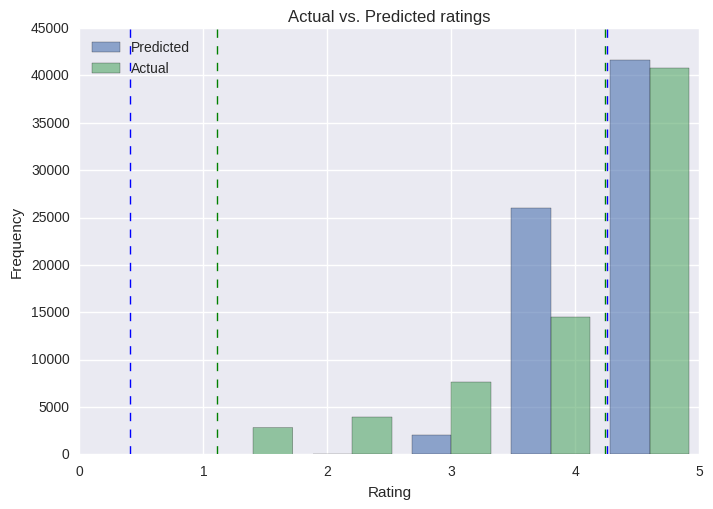

In [41]:
x = df['predicted_rating']
y = df['actual_rating']
data = np.vstack([x, y]).T
plt.hist(data,bins=5,alpha=0.6, label=['Predicted', 'Actual'])
plt.axvline(x.mean(), color='b',linestyle='dashed', linewidth=1)
plt.axvline(x.std(), color='b', linestyle='dashed', linewidth=1)

plt.axvline(y.mean(), color='g', linestyle='dashed',linewidth=1)
plt.axvline(y.std(), color='g', linestyle='dashed', linewidth=1)
plt.legend(loc='upper left')

plt.title("Actual vs. Predicted ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()